In [243]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
%matplotlib inline

In [219]:
data = pd.read_csv("AviationData.txt", delimiter="|")
data.describe()

,Event Id,Investigation Type,Accident Number,Event Date,Location,Country,Latitude,Longitude,Airport Code,Airport Name,...,Air Carrier,Total Fatal Injuries,Total Serious Injuries,Total Minor Injuries,Total Uninjured,Weather Condition,Broad Phase of Flight,Report Status,Publication Date,
count,74428,74428,74428,74428,74428,74428,74428,74428,74428,74428,...,74428,74428,74428,74428,74428,74428,74428,74428,74428,74428
unique,73349,2,74428,11561,23841,171,14701,15586,9200,21565,...,2726,115,41,62,359,4,13,4,3139,1
top,20001212X19172,Accident,ERA14FA068,06/30/1984,"ANCHORAGE, AK",United States,,,,,...,,0,0,0,1,VMC,LANDING,Probable Cause,,
freq,3,71584,1,25,372,70757,53144,53153,32705,29806,...,70752,40380,42975,40358,21333,66572,17747,69938,12840,74428


In [220]:
def print_row_col(data):

    n_rows = data.shape[0]
    n_cols = data.shape[1]
    print(f"There are {n_rows} rows in the airplane crash dataset")
    print(f"There are {n_cols} columns in the airplane crash dataset")

In [221]:
def clean_data(data):

    # Drop columns that seem to have significant missing data or are not relevant
    data.drop(columns=['Event Id ', ' Registration Number ', ' Make ', ' Model ', ' Amateur Built ', ' FAR Description ', ' Schedule ', ' Air Carrier ', ' Broad Phase of Flight ', ' Report Status ', ' Publication Date '], inplace=True)
    data = data.iloc[:, :-1]
    # Replace missing data in columns with NaN
    data.replace(r'^\s*$', np.NaN, regex=True, inplace=True)
    # Remove extra whitespace in columns 
    data = data.apply(lambda x: x.str.strip() if x.dtype == "object" else x).rename(columns=lambda x: x.strip())
    # Decided to drop these columns
    data.drop(columns=['Total Serious Injuries', 'Total Minor Injuries', 'Total Uninjured'], inplace=True) # Columns that appear to be primarily empty
    # Fill NaN values with zero
    data.fillna(value={'Total Fatal Injuries': 0, 'Aircraft Category': 'Airplane'}, inplace=True)
    # Convert to int
    data['Total Fatal Injuries'] = data['Total Fatal Injuries'].astype(int)
    data['is_fatal'] = data['Total Fatal Injuries'].map(lambda x: 1 if x > 0 else 0)

    return data




In [222]:
# Look at data before proprocessing
print(data.describe())
print(data.head(1))
print_row_col(data)


              Event Id   Investigation Type   Accident Number    Event Date   \
count             74428                74428             74428         74428   
unique            73349                    2             74428         11561   
top     20001212X19172             Accident        ERA14FA068    06/30/1984    
freq                  3                71584                 1            25   

              Location          Country   Latitude   Longitude   \
count             74428            74428      74428       74428   
unique            23841              171      14701       15586   
top      ANCHORAGE, AK    United States                           
freq                372            70757      53144       53153   

        Airport Code   Airport Name   ...  Air Carrier   \
count           74428          74428  ...         74428   
unique           9200          21565  ...          2726   
top                                   ...                 
freq            32705      

In [223]:
# Preprocess data
data = clean_data(data)

/Users/adam/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:5239: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [224]:
# Look at data after proprocessing
print(data.describe())
print(data.head(1))
print_row_col(data)


       Total Fatal Injuries      is_fatal
count          74428.000000  74428.000000
mean               0.563189      0.198608
std                5.063542      0.398955
min                0.000000      0.000000
25%                0.000000      0.000000
50%                0.000000      0.000000
75%                0.000000      0.000000
max              349.000000      1.000000
  Investigation Type Accident Number  Event Date          Location  \
0           Accident      ERA14FA068  12/08/2013  Jacksonville, FL   

         Country   Latitude   Longitude Airport Code  \
0  United States  30.319723  -81.514167          CRG   

                     Airport Name Injury Severity Aircraft Damage  \
0  Jacksonville Executive Airport        Fatal(3)     Substantial   

  Aircraft Category Number of Engines    Engine Type Purpose of Flight  \
0          Airplane                 2  Reciprocating          Personal   

   Total Fatal Injuries Weather Condition  is_fatal  
0                     3   

In [225]:
# Look at NaNs
print(data.isna().sum())
print(data.isna().mean()*100) # Percent of NaNs in data for each column


Investigation Type          0
Accident Number             0
Event Date                  2
Location                   89
Country                   511
Latitude                53144
Longitude               53153
Airport Code            32705
Airport Name            29806
Injury Severity            56
Aircraft Damage          2161
Aircraft Category           0
Number of Engines        3230
Engine Type              2721
Purpose of Flight        3010
Total Fatal Injuries        0
Weather Condition        1516
is_fatal                    0
dtype: int64
Investigation Type       0.000000
Accident Number          0.000000
Event Date               0.002687
Location                 0.119579
Country                  0.686570
Latitude                71.403235
Longitude               71.415328
Airport Code            43.941796
Airport Name            40.046757
Injury Severity          0.075241
Aircraft Damage          2.903477
Aircraft Category        0.000000
Number of Engines        4.339765
Engin

7509

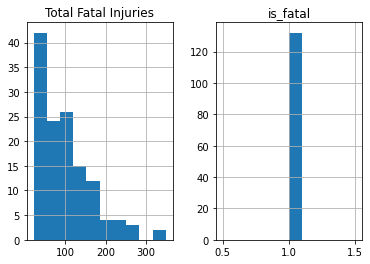

In [226]:
# Looking at histogram of fatal injuries above 100
data[data['Total Fatal Injuries'] > 20].hist() # looking at only plane crashes with greater than 100 fatalities
len(data[data['Total Fatal Injuries'] > 1]) # Dropped down to 54 plane crashes

In [227]:
# Make new dataframe filtered by > 25 Total Fatal Injuries
data_sig_fatal = data[data['Total Fatal Injuries'] > 25] # Drop to only crashes including more than 25 fatalities

In [228]:
data.loc[data['Event Date']=='09/11/2001'] # Looking at 9/11 attacks 


,Investigation Type,Accident Number,Event Date,Location,Country,Latitude,Longitude,Airport Code,Airport Name,Injury Severity,Aircraft Damage,Aircraft Category,Number of Engines,Engine Type,Purpose of Flight,Total Fatal Injuries,Weather Condition,is_fatal
22942,Accident,DCA01MA065,09/11/2001,"Shanksville, PA",United States,NaN,NaN,NaN,NaN,Fatal(44),Destroyed,Airplane,NaN,NaN,NaN,44,NaN,1
22943,Accident,DCA01MA064,09/11/2001,"Arlington, VA",United States,NaN,NaN,NaN,NaN,Fatal(64),Destroyed,Airplane,NaN,NaN,NaN,64,NaN,1
22944,Accident,DCA01MA063,09/11/2001,"New York City, NY",United States,NaN,NaN,NaN,NaN,Fatal(65),Destroyed,Airplane,2,Turbo Fan,NaN,65,NaN,1
22945,Accident,DCA01MA060,09/11/2001,"New York City, NY",United States,NaN,NaN,NaN,NaN,Fatal(92),Destroyed,Airplane,2,Turbo Fan,NaN,92,NaN,1


In [229]:
data['Country'].value_counts()
# Interesting to see most of the large plane crashes are in the US folowed by Colombia, Peru, Nigeria

United States    70757
Canada             204
Mexico             188
Bahamas            182
Australia          158
                 ...  
Eritrea              1
Ivory Coast          1
Niger                1
Madagascar           1
Bermuda              1
Name: Country, Length: 170, dtype: int64

In [230]:
# Check fatality rate for plane crashes?
# Is Fatal?
# Are flights overall becoming more safe?
# Are large planes safer than small planes?
# Is it dangerous to fly in bad weather?

<!-- Narrow to United states
Lat/Long only 30% of data
Plot by state maybe
Fatality rate {by_state, by_plane_type, by_year, by_weather}
Build classifier based off US to predict fatalities -->

In [296]:
# Add column is_fatal
US_accidents = data[data['Country'] == 'United States']
US_accidents

,Investigation Type,Accident Number,Event Date,Location,Country,Latitude,Longitude,Airport Code,Airport Name,Injury Severity,Aircraft Damage,Aircraft Category,Number of Engines,Engine Type,Purpose of Flight,Total Fatal Injuries,Weather Condition,is_fatal
0,Accident,ERA14FA068,12/08/2013,"Jacksonville, FL",United States,30.319723,-81.514167,CRG,Jacksonville Executive Airport,Fatal(3),Substantial,Airplane,2,Reciprocating,Personal,3,IMC,1
1,Accident,ERA14FA066,12/06/2013,"Sebring, FL",United States,27.463333,-81.366667,SEF,Sebring Regional Airport,Fatal(1),Destroyed,Helicopter,1,Unknown,Positioning,1,NaN,1
2,Accident,ANC14CA010,12/04/2013,"Soldotna, AK",United States,NaN,NaN,NaN,NaN,NaN,NaN,Airplane,NaN,NaN,NaN,0,NaN,0
3,Accident,ERA14CA062,12/03/2013,"Hendersonville, NC",United States,NaN,NaN,NaN,NaN,NaN,NaN,Airplane,NaN,NaN,NaN,0,NaN,0
4,Accident,ERA14LA059,12/02/2013,"Trenton, SC",United States,33.736944,-81.818611,6J6,Edgefield County Airport,Non-Fatal,Substantial,Airplane,1,NaN,Personal,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74422,Accident,LAX96LA321,06/19/1977,"EUREKA, CA",United States,NaN,NaN,NaN,NaN,Fatal(2),Destroyed,Airplane,1,Reciprocating,Personal,2,IMC,1
74423,Accident,NYC07LA005,08/30/1974,"Saltville, VA",United States,36.922223,-81.878056,NaN,NaN,Fatal(3),Destroyed,Airplane,1,Reciprocating,Personal,3,IMC,1
74424,Accident,LAX94LA336,07/19/1962,"BRIDGEPORT, CA",United States,NaN,NaN,NaN,NaN,Fatal(4),Destroyed,Airplane,1,Reciprocating,Personal,4,UNK,1
74425,Accident,SEA87LA080,10/24/1948,"MOOSE CREEK, ID",United States,NaN,NaN,NaN,NaN,Fatal(2),Destroyed,Airplane,1,Reciprocating,Personal,2,UNK,1


 CA              7811
 FL              4938
 AK              4912
 TX              4910
 AZ              2410
                 ... 
Kauai               1
 San Juan Is.       1
 Maui               1
 MP                 1
 FT. MYER           1
Name: Location_State, Length: 79, dtype: int64


/Users/adam/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


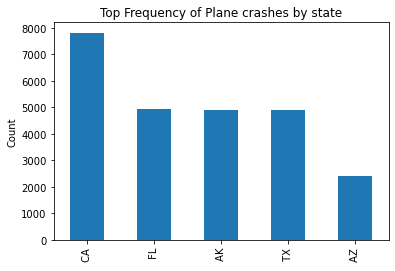

In [297]:
# Location (Stolen from Ryan's notebook)
US_accidents[['Location_City','Location_State']] = US_accidents['Location'].str.split(',',expand=True)[[0,1]]
US_accidents[['Location','Location_City','Location_State']].head()

US_accidents.groupby(['Location_State']).count()

freq_by_state = US_accidents['Location_State'].value_counts()
print(freq_by_state)
freq_by_state[:5].plot(kind='bar', title='Top Frequency of Plane crashes by state', ylabel='Count')



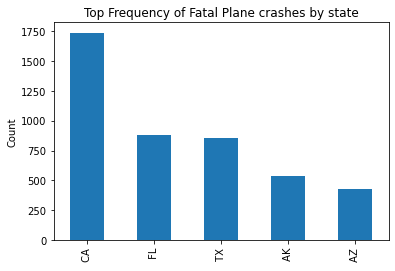

In [298]:
#US_accidents
freq_is_fatal = US_accidents[US_accidents['is_fatal'] == 1]
freq_is_fatal
freq_is_fatal = freq_is_fatal['Location_State'].value_counts()
freq_is_fatal[:5].plot(kind='bar', title='Top Frequency of Fatal Plane crashes by state', ylabel='Count')

## Logistic Regression to Predict if plane crash is fatal or not


In [299]:
print(US_accidents.columns)
print(US_accidents.dtypes)
print(US_accidents.head())

Index(['Investigation Type', 'Accident Number', 'Event Date', 'Location',
       'Country', 'Latitude', 'Longitude', 'Airport Code', 'Airport Name',
       'Injury Severity', 'Aircraft Damage', 'Aircraft Category',
       'Number of Engines', 'Engine Type', 'Purpose of Flight',
       'Total Fatal Injuries', 'Weather Condition', 'is_fatal',
       'Location_City', 'Location_State'],
      dtype='object')
Investigation Type      object
Accident Number         object
Event Date              object
Location                object
Country                 object
Latitude                object
Longitude               object
Airport Code            object
Airport Name            object
Injury Severity         object
Aircraft Damage         object
Aircraft Category       object
Number of Engines       object
Engine Type             object
Purpose of Flight       object
Total Fatal Injuries     int64
Weather Condition       object
is_fatal                 int64
Location_City           object
Loc

In [300]:
# Filling NaNs with most frequent
US_accidents['Weather Condtion'] = US_accidents['Weather Condition'].fillna(US_accidents.mode().iloc[0])
US_accidents

/Users/adam/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Investigation Type,Accident Number,Event Date,Location,Country,Latitude,Longitude,Airport Code,Airport Name,Injury Severity,...,Aircraft Category,Number of Engines,Engine Type,Purpose of Flight,Total Fatal Injuries,Weather Condition,is_fatal,Location_City,Location_State,Weather Condtion
0,Accident,ERA14FA068,12/08/2013,"Jacksonville, FL",United States,30.319723,-81.514167,CRG,Jacksonville Executive Airport,Fatal(3),...,Airplane,2,Reciprocating,Personal,3,IMC,1,Jacksonville,FL,IMC
1,Accident,ERA14FA066,12/06/2013,"Sebring, FL",United States,27.463333,-81.366667,SEF,Sebring Regional Airport,Fatal(1),...,Helicopter,1,Unknown,Positioning,1,NaN,1,Sebring,FL,NaN
2,Accident,ANC14CA010,12/04/2013,"Soldotna, AK",United States,NaN,NaN,NaN,NaN,NaN,...,Airplane,NaN,NaN,NaN,0,NaN,0,Soldotna,AK,NaN
3,Accident,ERA14CA062,12/03/2013,"Hendersonville, NC",United States,NaN,NaN,NaN,NaN,NaN,...,Airplane,NaN,NaN,NaN,0,NaN,0,Hendersonville,NC,NaN
4,Accident,ERA14LA059,12/02/2013,"Trenton, SC",United States,33.736944,-81.818611,6J6,Edgefield County Airport,Non-Fatal,...,Airplane,1,NaN,Personal,0,NaN,0,Trenton,SC,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74422,Accident,LAX96LA321,06/19/1977,"EUREKA, CA",United States,NaN,NaN,NaN,NaN,Fatal(2),...,Airplane,1,Reciprocating,Personal,2,IMC,1,EUREKA,CA,IMC
74423,Accident,NYC07LA005,08/30/1974,"Saltville, VA",United States,36.922223,-81.878056,NaN,NaN,Fatal(3),...,Airplane,1,Reciprocating,Personal,3,IMC,1,Saltville,VA,IMC
74424,Accident,LAX94LA336,07/19/1962,"BRIDGEPORT, CA",United States,NaN,NaN,NaN,NaN,Fatal(4),...,Airplane,1,Reciprocating,Personal,4,UNK,1,BRIDGEPORT,CA,UNK
74425,Accident,SEA87LA080,10/24/1948,"MOOSE CREEK, ID",United States,NaN,NaN,NaN,NaN,Fatal(2),...,Airplane,1,Reciprocating,Personal,2,UNK,1,MOOSE CREEK,ID,UNK


In [304]:

#Fill Nan's with most frequent damage value of 'Substantial'
US_accidents['Aircraft Damage'].value_counts()
US_accidents['Aircraft Damage'].fillna('Substantial', inplace=True) # Assume NaNs are VMC conditions
# Map strings to ints
US_accidents['Aircraft Damage'] = US_accidents['Aircraft Damage'].map({'Substantial': 1, 'Destroyed': 2, 'Minor': 0})
US_accidents['Aircraft Damage'].unique()

/Users/adam/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/Users/adam/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


array([1, 2, 0])

In [305]:
US_accidents['Number of Engines'].value_counts()
US_accidents['Number of Engines'].fillna(1, inplace=True)
US_accidents['Number of Engines'] = US_accidents['Number of Engines'].astype(int)
US_accidents['Number of Engines'].unique()

/Users/adam/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/Users/adam/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


array([2, 1, 4, 0, 3])

In [306]:
## Convert NaNs to most frequent value


US_accidents['Weather Condition'].value_counts()
US_accidents['Weather Condition'].fillna('VMC', inplace=True) # Assume NaNs are VMC conditions
US_accidents['Weather Condition'].isna().sum()
US_accidents['Weather Condition'] = US_accidents['Weather Condition'].map({'IMC': 0, 'VMC': 1, 'UNK': 2})
US_accidents['Weather Condition'].unique()

/Users/adam/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/Users/adam/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


array([0, 1, 2])

In [307]:
# x = US_accidents[['Aircraft Damage', 'Aircraft Category', 'Number of Engines', 'Purpose of Flight', 'Weather Condition']]
x = US_accidents[['Aircraft Damage', 'Number of Engines', 'Weather Condition']]
y = US_accidents['is_fatal']

In [308]:
model = LogisticRegression(solver='liblinear', random_state=0)

In [309]:
model.fit(x,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [313]:
model.classes_
model.predict_proba(x)
model.predict(x)
model.score(x, y)

0.8743445878146332

In [314]:
confusion_matrix(y, model.predict(x))

array([[52365,  5303],
       [ 3588,  9501]])

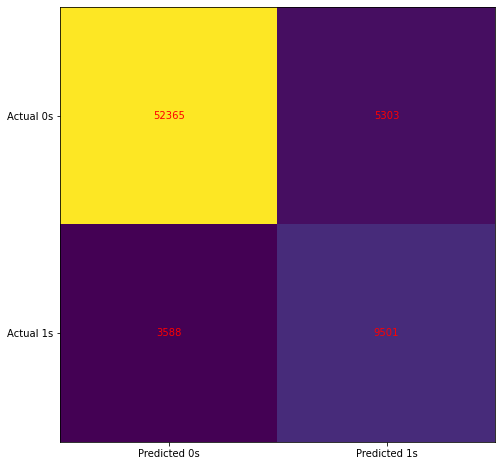

In [315]:
cm = confusion_matrix(y, model.predict(x))

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

In [316]:
print(classification_report(y, model.predict(x)))

              precision    recall  f1-score   support

           0       0.94      0.91      0.92     57668
           1       0.64      0.73      0.68     13089

    accuracy                           0.87     70757
   macro avg       0.79      0.82      0.80     70757
weighted avg       0.88      0.87      0.88     70757

